In [ ]:
# ## Run 1. 

# import os
# from google import genai
# from google.oauth2 import service_account  # 인증 객체 생성을 위해 필요
# from google.genai.types import GenerateContentConfig

# # 1. JSON 키 파일 경로를 환경 변수에서 가져오기 (보안 강화)
# # 환경 변수 설정 방법:
# # export GOOGLE_APPLICATION_CREDENTIALS="/path/to/your/key.json"
# # export GOOGLE_CLOUD_PROJECT="your-project-id"
# KEY_PATH ="/home/syaro/stan_GCP_API.json"
# PROJECT_ID = "composed-hash-485105-k5"
# LOCATION = "us-central1"

# # 2. 인증 객체 생성 시 SCOPES 명시 (필수)
# # Vertex AI에 접근하기 위한 클라우드 플랫폼 스코프를 추가합니다.
# scopes = ['https://www.googleapis.com/auth/cloud-platform']
# credentials = service_account.Credentials.from_service_account_file(
#     KEY_PATH, 
#     scopes=scopes
# )

# # 3. Client 설정 시 credentials 전달
# client = genai.Client(
#     vertexai=True, 
#     project=PROJECT_ID, 
#     location=LOCATION,
#     credentials=credentials  # <--- 문자열이 아닌 객체를 전달!
# )

# # ============================================
# # 모델 설정
# # ============================================
# MODEL_ID = "gemini-2.5-flash"



/home/syaro/miniconda3/envs/minigrid/lib/python3.9/site-packages/google/auth/__init__.py:54: FutureWarning: 
    You are using a Python version 3.9 past its end of life. Google will update
    google-auth with critical bug fixes on a best-effort basis, but not
    with any other fixes or features. Please upgrade your Python version,
    and then update google-auth.
    
  warnings.warn(eol_message.format("3.9"), FutureWarning)
/home/syaro/miniconda3/envs/minigrid/lib/python3.9/site-packages/google/oauth2/__init__.py:40: FutureWarning: 
    You are using a Python version 3.9 past its end of life. Google will update
    google-auth with critical bug fixes on a best-effort basis, but not
    with any other fixes or features. Please upgrade your Python version,
    and then update google-auth.
    
  warnings.warn(eol_message.format("3.9"), FutureWarning)


In [3]:
## Run 2. 

## Utility Functions
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# 일본어/한국어/중국어 폰트 설정
def setup_cjk_font():
    """CJK(중국어, 일본어, 한국어) 문자를 지원하는 폰트 찾기 및 설정"""
    # Linux에서 일반적으로 사용 가능한 CJK 폰트 목록
    cjk_fonts = [
        'Noto Sans CJK JP',  # Google Noto Sans (일본어)
        'Noto Sans CJK KR',  # Google Noto Sans (한국어)
        'Noto Sans CJK SC',  # Google Noto Sans (중국어 간체)
        'Noto Sans CJK TC',  # Google Noto Sans (중국어 번체)
        'Noto Sans JP',
        'Noto Sans KR',
        'Noto Sans SC',
        'Noto Sans TC',
        'DejaVu Sans',  # 기본 폰트 (CJK 미지원)
    ]
    
    # 시스템에 설치된 폰트 목록 가져오기
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    # 사용 가능한 CJK 폰트 찾기
    for font_name in cjk_fonts:
        if font_name in available_fonts:
            plt.rcParams['font.family'] = font_name
            print(f"폰트 설정: {font_name}")
            return font_name
    
    # 폰트를 찾지 못한 경우 경고
    print("경고: CJK 폰트를 찾을 수 없습니다. 일본어/한국어/중국어가 제대로 표시되지 않을 수 있습니다.")
    print("설치 방법: sudo apt-get install fonts-noto-cjk")
    return None

# 폰트 설정
setup_cjk_font()

폰트 설정: Noto Sans CJK JP


'Noto Sans CJK JP'

Output text: 日本で一番高い山は**富士山**です。

標高は**3,776メートル**で、静岡県と山梨県にまたがっています。


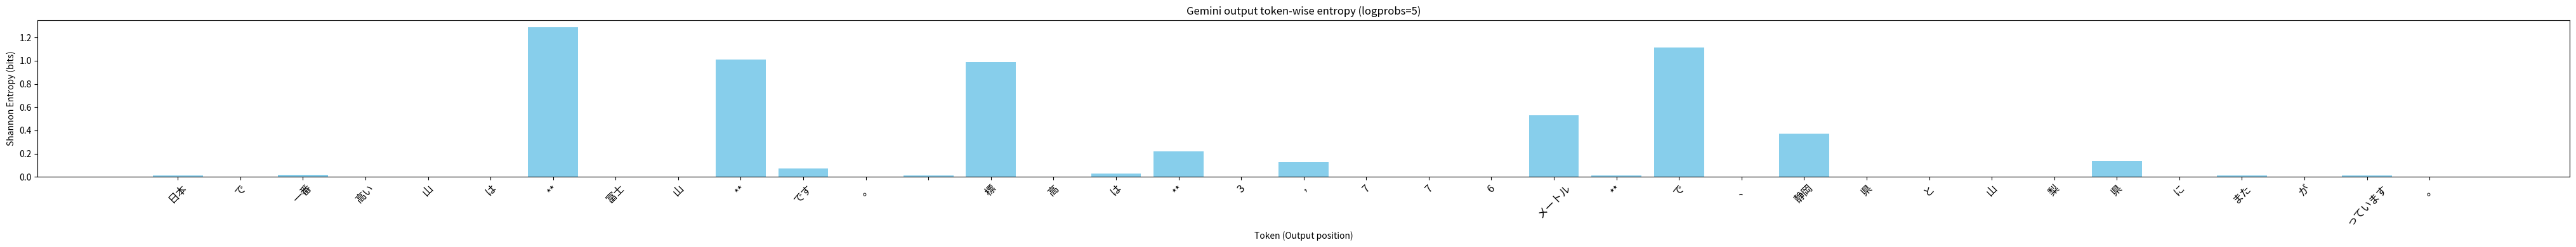

In [4]:


# Gemini-2.5-flash 모델 호출: logprobs=5로 각 위치의 토큰에 대해 상위 5개 logprob 정보를 요청
response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents='日本で一番高い山は？',
    config=genai.types.GenerateContentConfig(
        response_logprobs=True,
        logprobs=5
    )
)

# 출력 문장 추출
output_text = response.candidates[0].content.parts[0].text
print("Output text:", output_text)

# 각 토큰 위치별 토큰 및 top-5 logprob로 shannon entropy 계산
logprobs_result = response.candidates[0].logprobs_result
token_entropies = []
tokens = []

# logprobs_result 구조에 맞게 수정
for i, chosen in enumerate(logprobs_result.chosen_candidates):
    tokens.append(chosen.token)
    
    # top_candidates에서 해당 위치의 상위 후보들 가져오기
    if i < len(logprobs_result.top_candidates):
        top_candidates = logprobs_result.top_candidates[i]
        # top_candidates.candidates에서 확률 추출
        probs = []
        for cand in top_candidates.candidates:
            probs.append(np.exp(cand.log_probability))  # log_probability → 확률
        
        probs_sum = np.sum(probs)
        # (혹시 확률합이 1이 아니면 정규화)
        if probs_sum > 0:
            probs = [p / probs_sum for p in probs]
        else:
            # fallback: 확률이 모두 비정상적으로 0이면 균등분포 가정
            probs = [1/len(top_candidates.candidates)] * len(top_candidates.candidates)
        
        # shannon entropy 계산
        entropy = -np.sum([p*np.log2(p) if p > 0 else 0 for p in probs])
        token_entropies.append(entropy)
    else:
        # top_candidates가 없는 경우 (선택된 토큰만 사용)
        token_entropies.append(0.0)

# 결과 시각화
plt.figure(figsize=(max(6, len(tokens) * 1.1), 4))
plt.bar(range(len(tokens)), token_entropies, color='skyblue')
plt.xticks(range(len(tokens)), tokens, rotation=45, fontsize=12)
plt.xlabel('Token (Output position)')
plt.ylabel('Shannon Entropy (bits)')
plt.title('Gemini output token-wise entropy (logprobs=5)')
plt.tight_layout()
plt.show()


이미지 로드 완료: ./minigrid_debug.png (448x448)

=== 모델 출력 ===
east east east east


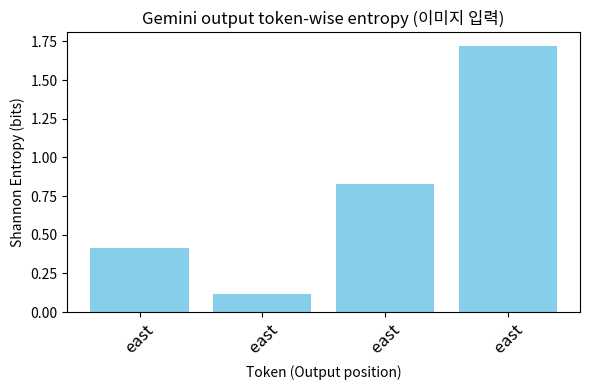


평균 토큰 엔트로피: 0.771 bits


In [11]:
## Experiment Related Variables 
# Image Directory
image_path = "./minigrid_debug.png"  # 여기에 이미지 경로 입력

# 프롬프트 설정: system prompt와 user prompt 분리
system_prompt = """
## ACTION SPACE (FUNDAMENTALS)
- "north" : Move North (Top)
- "south" : Move South (Bottom)
- "west" : Move West (Left)
- "east" : Move East (Right)
- "pickup:north" / "pickup:south" / "pickup:west" / "pickup:east" : Pick up object in the specified direction (robot will rotate to face that direction first)
- "drop" : Drop object
- "toggle" : Toggle/interact


## OUTPUT FORMAT (STRICTLY IMPORTANT) 
<action1> <action2> <action3> <action4>

## MOVEMENT RULES
- follow user prompt STRICTLY
- follow output action sequence format strictly (including sequence length)

"""  # 시스템 프롬프트 (모델의 역할/행동 정의)
user_prompt = "move toward kitchen"  # 사용자 프롬프트 (실제 요청 내용)




# 이미지 로드
from PIL import Image
import os

# 이미지 파일 존재 확인 및 로드
if not os.path.exists(image_path):
    print(f"경고: 이미지 파일을 찾을 수 없습니다: {image_path}")
else:
    image = Image.open(image_path)
    print(f"이미지 로드 완료: {image_path} ({image.size[0]}x{image.size[1]})")
    

    
    # Gemini 모델 호출: system_instruction과 contents 분리
    # system_instruction: 모델의 행동을 정의하는 시스템 프롬프트
    # contents: 사용자 입력 (텍스트 + 이미지)
    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[user_prompt, image],  # 사용자 프롬프트와 이미지
        config=genai.types.GenerateContentConfig(
            system_instruction=system_prompt,  # 시스템 프롬프트 분리
            response_logprobs=True,
            logprobs=5,
            temperature=0.5,  # 높은 temperature (더 다양한 응답)
            thinking_config=genai.types.ThinkingConfig(thinking_budget=0)  # Thinking 비활성화
        )
    )
    
    # 출력 텍스트 추출
    output_text = response.candidates[0].content.parts[0].text
    print("\n=== 모델 출력 ===")
    print(output_text)
    
    # 각 토큰별 Shannon 엔트로피 계산
    logprobs_result = response.candidates[0].logprobs_result
    token_entropies = []
    tokens = []
    
    # 각 토큰 위치별로 엔트로피 계산
    for i, chosen in enumerate(logprobs_result.chosen_candidates):
        tokens.append(chosen.token)
        
        # top_candidates에서 상위 후보들의 확률 추출
        if i < len(logprobs_result.top_candidates):
            top_candidates = logprobs_result.top_candidates[i]
            
            # log_probability 추출
            log_probs = np.array([cand.log_probability for cand in top_candidates.candidates])
            
            # log-sum-exp를 사용한 정규화 (수치적 안정성)
            # softmax: p_i = exp(log_p_i) / sum(exp(log_p_j))
            # = exp(log_p_i - log_sum_exp(log_probs))
            log_sum_exp = np.log(np.sum(np.exp(log_probs)))
            normalized_log_probs = log_probs - log_sum_exp
            probs = np.exp(normalized_log_probs)
            
            # 확률 합이 1인지 확인 (디버깅용)
            # print(f"Token {i}: probs sum = {np.sum(probs):.6f}")
            
            # Shannon 엔트로피 계산: H = -Σ(p * log2(p))
            entropy = -np.sum([p * np.log2(p) if p > 0 else 0 for p in probs])
            token_entropies.append(entropy)
        else:
            # top_candidates가 없는 경우 엔트로피 0
            token_entropies.append(0.0)
    
    # 결과 시각화: 토큰별 엔트로피 막대 그래프
    plt.figure(figsize=(max(6, len(tokens) * 1.1), 4))
    plt.bar(range(len(tokens)), token_entropies, color='skyblue')
    plt.xticks(range(len(tokens)), tokens, rotation=45, fontsize=12)
    plt.xlabel('Token (Output position)')
    plt.ylabel('Shannon Entropy (bits)')
    plt.title('Gemini output token-wise entropy (이미지 입력)')
    plt.tight_layout()
    plt.show()
    
    # 평균 엔트로피 출력
    avg_entropy = np.mean(token_entropies)
    print(f"\n평균 토큰 엔트로피: {avg_entropy:.3f} bits")

In [13]:
"""
P(True) 기법 테스트 코드
Reference: "Language Models (Mostly) Know What They Know" (Kadavath et al., Anthropic, 2022)

- 1차 출력: Action sequence 생성 및 파싱
- 2차 출력: Self-evaluation ("Is the above answer correct?") 질문
- P(True): "Yes" / "True" 토큰의 logprob을 신뢰도로 사용
- 비교: 생성 시점 entropy vs P(True) entropy
"""

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# ============================================
# 실험 설정
# ============================================
image_path = "./minigrid_debug.png"

system_prompt = """
## ACTION SPACE (FUNDAMENTALS)
- "north" : Move North (Top)
- "south" : Move South (Bottom)
- "west" : Move West (Left)
- "east" : Move East (Right)
- "pickup:north" / "pickup:south" / "pickup:west" / "pickup:east" : Pick up object in the specified direction
- "drop" : Drop object
- "toggle" : Toggle/interact

## OUTPUT FORMAT (STRICTLY IMPORTANT) 
<action1> <action2> <action3> <action4>

## MOVEMENT RULES
- follow user prompt STRICTLY
- follow output action sequence format strictly (including sequence length)
"""
# - follow user prompt as much as possible
# - if user prompt is not clear, do random movement

user_prompt = "move toward hatsune miku"

# ============================================
# 1단계: Action Sequence 생성 (1차 출력)
# ============================================
print("=" * 60)
print("1단계: Action Sequence 생성")
print("=" * 60)

image = Image.open(image_path)
print(f"이미지 로드 완료: {image_path} ({image.size[0]}x{image.size[1]})")

# 1차 응답 생성
response_1st = client.models.generate_content(
    model=MODEL_ID,
    contents=[user_prompt, image],
    config=genai.types.GenerateContentConfig(
        system_instruction=system_prompt,
        response_logprobs=True,
        logprobs=5,
        temperature=0.5,
        thinking_config=genai.types.ThinkingConfig(thinking_budget=0)
    )
)

# 1차 출력 파싱
output_text_1st = response_1st.candidates[0].content.parts[0].text.strip()
action_list = output_text_1st.split()  # 공백으로 분리하여 action list 생성

print(f"\n[1차 출력 - Raw]: {output_text_1st}")
print(f"[1차 출력 - Parsed Action List]: {action_list}")

# 1차 출력의 토큰별 엔트로피 계산
logprobs_result_1st = response_1st.candidates[0].logprobs_result
entropies_1st = []
tokens_1st = []

for i, chosen in enumerate(logprobs_result_1st.chosen_candidates):
    tokens_1st.append(chosen.token)
    
    if i < len(logprobs_result_1st.top_candidates):
        top_candidates = logprobs_result_1st.top_candidates[i]
        log_probs = np.array([cand.log_probability for cand in top_candidates.candidates])
        
        # log-sum-exp 정규화
        log_sum_exp = np.log(np.sum(np.exp(log_probs)))
        normalized_log_probs = log_probs - log_sum_exp
        probs = np.exp(normalized_log_probs)
        
        # Shannon 엔트로피
        entropy = -np.sum([p * np.log2(p) if p > 0 else 0 for p in probs])
        entropies_1st.append(entropy)
    else:
        entropies_1st.append(0.0)

print(f"\n[1차 출력 - 평균 엔트로피]: {np.mean(entropies_1st):.4f} bits")

# ============================================
# 2단계: P(True) Self-Evaluation (2차 출력)
# ============================================
print("\n" + "=" * 60)
print("2단계: P(True) Self-Evaluation")
print("=" * 60)

# Self-evaluation 프롬프트 구성
# action 개수에 맞게 Yes/No 출력 형식 생성
num_actions = len(action_list)
yes_no_format = " ".join(["<Yes/No>"] * num_actions)
action_numbered = "\n".join([f"  {i+1}. {action}" for i, action in enumerate(action_list)])

self_eval_system_prompt = f"""
You are evaluating whether EACH action in a proposed sequence is correct for a given task.
For each action, answer with "Yes" (correct) or "No" (incorrect).
Output format: exactly {num_actions} answers separated by space.
Example: Yes Yes No Yes
"""

self_eval_user_prompt = f"""
## Original Task
User command: "{user_prompt}"

## Proposed Action Sequence ({num_actions} actions)
{action_numbered}

## Question
Given the image and the user command, evaluate EACH action individually.
Is each action correct and appropriate for accomplishing the task?

Output exactly {num_actions} answers (Yes or No), one for each action, separated by space:
Format: {yes_no_format}
Answer:
"""

print(f"[Self-Evaluation Prompt]:\n{self_eval_user_prompt}")
print(f"[Expected output format]: {num_actions} Yes/No answers")

# 2차 응답 생성 (Self-evaluation)
response_2nd = client.models.generate_content(
    model=MODEL_ID,
    contents=[self_eval_user_prompt, image],
    config=genai.types.GenerateContentConfig(
        system_instruction=self_eval_system_prompt,
        response_logprobs=True,
        logprobs=5,
        temperature=0.5,  # Deterministic for evaluation
        thinking_config=genai.types.ThinkingConfig(thinking_budget=0)
    )
)

output_text_2nd = response_2nd.candidates[0].content.parts[0].text.strip()
print(f"\n[2차 출력 - Self-Evaluation 결과]: {output_text_2nd}")

# P(True) 계산: 각 action에 대한 Yes/No 토큰의 logprob 추출
logprobs_result_2nd = response_2nd.candidates[0].logprobs_result
entropies_2nd = []
tokens_2nd = []

# 각 action별 P(True) 저장
p_true_per_action = []  # (action_idx, token, logprob, prob, entropy)
action_eval_idx = 0  # 현재 평가 중인 action index

for i, chosen in enumerate(logprobs_result_2nd.chosen_candidates):
    token = chosen.token
    tokens_2nd.append(token)
    
    if i < len(logprobs_result_2nd.top_candidates):
        top_candidates = logprobs_result_2nd.top_candidates[i]
        log_probs = np.array([cand.log_probability for cand in top_candidates.candidates])
        candidate_tokens = [cand.token for cand in top_candidates.candidates]
        
        # log-sum-exp 정규화
        log_sum_exp = np.log(np.sum(np.exp(log_probs)))
        normalized_log_probs = log_probs - log_sum_exp
        probs = np.exp(normalized_log_probs)
        
        # Shannon 엔트로피
        entropy = -np.sum([p * np.log2(p) if p > 0 else 0 for p in probs])
        entropies_2nd.append(entropy)
        
        # "Yes" 또는 "No" 토큰 발견 시 해당 action의 P(True) 저장
        if token.lower().strip() in ["yes", "no", "true", "false"] and action_eval_idx < num_actions:
            logprob = chosen.log_probability
            prob = np.exp(logprob)
            is_yes = token.lower().strip() in ["yes", "true"]
            
            p_true_per_action.append({
                'action_idx': action_eval_idx,
                'action': action_list[action_eval_idx] if action_eval_idx < len(action_list) else "N/A",
                'token': token,
                'logprob': logprob,
                'prob': prob,
                'entropy': entropy,
                'is_yes': is_yes,
                'top_candidates': list(zip(candidate_tokens, log_probs.tolist(), probs.tolist()))
            })
            
            print(f"\n[Action {action_eval_idx + 1}] '{action_list[action_eval_idx] if action_eval_idx < len(action_list) else 'N/A'}'")
            print(f"  평가: '{token}', Logprob: {logprob:.4f}, Prob: {prob:.4f}, Entropy: {entropy:.4f}")
            print(f"  Top-5 candidates:")
            for j, (t, lp, p) in enumerate(zip(candidate_tokens, log_probs, probs)):
                marker = " <--" if t.lower().strip() == token.lower().strip() else ""
                print(f"    {j+1}. '{t}': logprob={lp:.4f}, prob={p:.4f}{marker}")
            
            action_eval_idx += 1
    else:
        entropies_2nd.append(0.0)

print(f"\n[2차 출력 - 평균 엔트로피]: {np.mean(entropies_2nd):.4f} bits")
print(f"[평가된 action 수]: {len(p_true_per_action)} / {num_actions}")

# P(True) 평균 계산 (Yes/True 토큰들의 확률 평균)
p_true_prob = None
p_true_logprob = None
if p_true_per_action:
    yes_probs = [p['prob'] for p in p_true_per_action if p['is_yes']]
    yes_logprobs = [p['logprob'] for p in p_true_per_action if p['is_yes']]
    if yes_probs:
        p_true_prob = np.mean(yes_probs)
        p_true_logprob = np.mean(yes_logprobs)

# ============================================
# 3단계: 결과 비교 및 시각화
# ============================================
print("\n" + "=" * 60)
print("3단계: 결과 비교")
print("=" * 60)

# 요약 통계
print(f"\n[비교 요약]")
print(f"  1차 출력 (Generation):")
print(f"    - Action Sequence: {output_text_1st}")
print(f"    - 토큰 수: {len(tokens_1st)}")
print(f"    - 평균 엔트로피: {np.mean(entropies_1st):.4f} bits")
print(f"    - 최대 엔트로피: {np.max(entropies_1st):.4f} bits")
print(f"    - 최소 엔트로피: {np.min(entropies_1st):.4f} bits")

print(f"\n  2차 출력 (Self-Evaluation):")
print(f"    - 응답: {output_text_2nd}")
print(f"    - 토큰 수: {len(tokens_2nd)}")
print(f"    - 평균 엔트로피: {np.mean(entropies_2nd):.4f} bits")
if p_true_prob is not None:
    print(f"    - P(True/Yes): {p_true_prob:.4f}")
    print(f"    - P(True/Yes) Logprob: {p_true_logprob:.4f}")

# 시각화 1: 전체 토큰별 엔트로피
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1차 출력 엔트로피
ax1 = axes[0]
ax1.bar(range(len(tokens_1st)), entropies_1st, color='steelblue', alpha=0.8)
ax1.set_xticks(range(len(tokens_1st)))
ax1.set_xticklabels(tokens_1st, rotation=45, ha='right', fontsize=9)
ax1.set_xlabel('Token (Output position)')
ax1.set_ylabel('Shannon Entropy (bits)')
ax1.set_title(f'1차 출력: Generation Entropy\n(평균: {np.mean(entropies_1st):.4f} bits)')
ax1.axhline(y=np.mean(entropies_1st), color='red', linestyle='--', label=f'Mean: {np.mean(entropies_1st):.4f}')
ax1.legend()

# 2차 출력 엔트로피
ax2 = axes[1]
colors = ['coral' if t.lower().strip() in ['yes', 'no', 'true', 'false'] else 'steelblue' for t in tokens_2nd]
ax2.bar(range(len(tokens_2nd)), entropies_2nd, color=colors, alpha=0.8)
ax2.set_xticks(range(len(tokens_2nd)))
ax2.set_xticklabels(tokens_2nd, rotation=45, ha='right', fontsize=9)
ax2.set_xlabel('Token (Output position)')
ax2.set_ylabel('Shannon Entropy (bits)')
ax2.set_title(f'2차 출력: P(True) Self-Evaluation Entropy\n(평균: {np.mean(entropies_2nd):.4f} bits)')
ax2.axhline(y=np.mean(entropies_2nd), color='red', linestyle='--', label=f'Mean: {np.mean(entropies_2nd):.4f}')
ax2.legend()

plt.tight_layout()
plt.savefig('./p_true_entropy_comparison_all.png', dpi=150, bbox_inches='tight')
plt.show()

# 시각화 2: Action별 엔트로피 직접 비교 (1차 vs 2차)
if len(p_true_per_action) > 0:
    fig2, ax3 = plt.subplots(figsize=(12, 6))
    
    # 1차 출력에서 action 토큰만 추출하여 엔트로피 계산
    # action_list와 매칭되는 1차 출력 토큰의 엔트로피 추출
    entropies_1st_actions = []
    for action in action_list:
        # 1차 출력 토큰에서 해당 action을 찾음
        found = False
        for idx, token in enumerate(tokens_1st):
            if token.lower().strip() == action.lower().strip():
                entropies_1st_actions.append(entropies_1st[idx])
                found = True
                break
        if not found:
            entropies_1st_actions.append(0.0)  # 못 찾은 경우
    
    # 2차 출력 (P(True)) 엔트로피
    entropies_2nd_actions = [p['entropy'] for p in p_true_per_action]
    p_true_probs = [p['prob'] for p in p_true_per_action]
    eval_tokens = [p['token'] for p in p_true_per_action]
    
    # 비교할 수 있는 최소 길이
    min_len = min(len(action_list), len(entropies_1st_actions), len(entropies_2nd_actions))
    
    x = np.arange(min_len)
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, entropies_1st_actions[:min_len], width, label='1차 출력 (Generation)', color='steelblue', alpha=0.8)
    bars2 = ax3.bar(x + width/2, entropies_2nd_actions[:min_len], width, label='2차 출력 (P(True))', color='coral', alpha=0.8)
    
    # X축 라벨: action + 평가 결과
    x_labels = [f"{action_list[i]}\n({eval_tokens[i]})" for i in range(min_len)]
    ax3.set_xticks(x)
    ax3.set_xticklabels(x_labels, fontsize=10)
    ax3.set_xlabel('Action (평가 결과)')
    ax3.set_ylabel('Shannon Entropy (bits)')
    ax3.set_title('Action별 엔트로피 비교: 1차 출력 (Generation) vs 2차 출력 (P(True))')
    ax3.legend()
    
    # P(True) 확률 표시
    for i, (bar, prob, token) in enumerate(zip(bars2, p_true_probs[:min_len], eval_tokens[:min_len])):
        color = 'green' if token.lower().strip() in ['yes', 'true'] else 'red'
        ax3.annotate(f'P={prob:.3f}', 
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontsize=8, color=color)
    
    plt.tight_layout()
    plt.savefig('./p_true_entropy_comparison_actions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 수치 비교 테이블 출력
    print("\n" + "=" * 80)
    print("Action별 엔트로피 비교 테이블")
    print("=" * 80)
    print(f"{'Action':<15} {'평가':<6} {'1차 Entropy':<12} {'2차 Entropy':<12} {'P(True)':<10} {'차이':<10}")
    print("-" * 80)
    for i in range(min_len):
        diff = entropies_2nd_actions[i] - entropies_1st_actions[i]
        is_yes = p_true_per_action[i]['is_yes']
        print(f"{action_list[i]:<15} {eval_tokens[i]:<6} {entropies_1st_actions[i]:<12.4f} {entropies_2nd_actions[i]:<12.4f} {p_true_probs[i]:<10.4f} {diff:+.4f}")
    print("-" * 80)
    print(f"{'평균':<15} {'':<6} {np.mean(entropies_1st_actions[:min_len]):<12.4f} {np.mean(entropies_2nd_actions[:min_len]):<12.4f} {np.mean(p_true_probs[:min_len]):<10.4f} {np.mean(entropies_2nd_actions[:min_len]) - np.mean(entropies_1st_actions[:min_len]):+.4f}")
else:
    print("\n[경고] P(True) 평가 결과가 없습니다. 프롬프트나 모델 출력을 확인해주세요.")

print(f"\n그래프 저장 완료: ./p_true_entropy_comparison.png")

1단계: Action Sequence 생성
이미지 로드 완료: ./minigrid_debug.png (448x448)

[1차 출력 - Raw]: north north north north
[1차 출력 - Parsed Action List]: ['north', 'north', 'north', 'north']

[1차 출력 - 평균 엔트로피]: 0.5940 bits

2단계: P(True) Self-Evaluation
[Self-Evaluation Prompt]:

## Original Task
User command: "move toward hatsune miku"

## Proposed Action Sequence (4 actions)
  1. north
  2. north
  3. north
  4. north

## Question
Given the image and the user command, evaluate EACH action individually.
Is each action correct and appropriate for accomplishing the task?

Output exactly 4 answers (Yes or No), one for each action, separated by space:
Format: <Yes/No> <Yes/No> <Yes/No> <Yes/No>
Answer:

[Expected output format]: 4 Yes/No answers

[2차 출력 - Self-Evaluation 결과]: No No No No

[Action 1] 'north'
  평가: 'No', Logprob: -0.0906, Prob: 0.9134, Entropy: 0.4264
  Top-5 candidates:
    1. 'No': logprob=-0.0906, prob=0.9136 <--
    2. 'Yes': logprob=-2.4515, prob=0.0862
    3. 'The': logprob=-9.0293, pro

: 

1단계: Action Sequence 생성
Task: Go to the red apple and pick it up. The apple is located 2 cells up and 1 cell left from your current position.
Generated Action Sequence: up up left pickup:north

1단계 평균 Entropy: 0.2930 bits

2단계: P(True) Self-Evaluation
Self-Evaluation Answer: True

P(True) = 9.36308158030058e-05
P(False) = 0.4100170396604268
2단계 첫 토큰 Entropy: 0.9783 bits

비교 결과
1단계 평균 Entropy: 0.2930 bits
2단계 P(True) Entropy: 0.9783 bits
Entropy 차이: -0.6853 bits


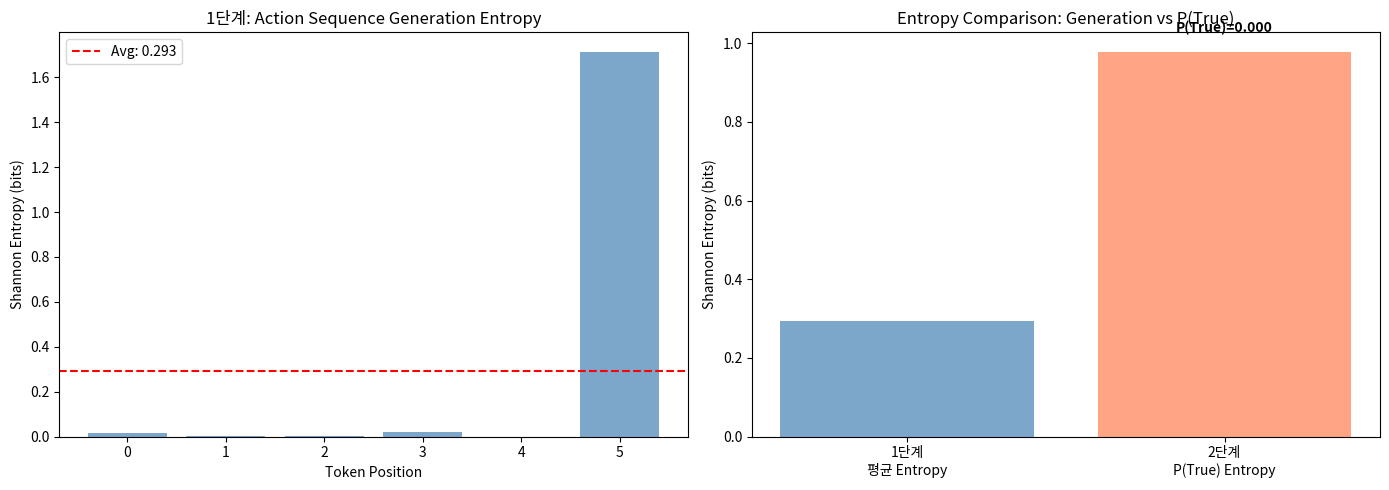


결과 저장: p_true_original_method.png


In [ ]:
## P(True) 방법론 (Kadavath et al., 2022 논문 원본 방식)
# 
# 핵심: 전체 답변에 대해 "한 번의" True/False 평가
# 1차: Action sequence 생성
# 2차: "Is the above answer correct?" → "True" 토큰의 확률 = P(True)

import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 설정
# ============================================
system_prompt = """You are a robot navigation assistant. 
Given a task, output a sequence of actions to complete it.
Available actions: up, down, left, right, pickup:north, pickup:south, pickup:east, pickup:west, drop
Output only the action sequence, separated by spaces."""

# 테스트용 task
# task = "Go to the red apple and pick it up. The apple is located 2 cells up and 1 cell left from your current position."
task = "do random movement"
# ============================================
# 1단계: Action Sequence 생성
# ============================================
print("=" * 60)
print("1단계: Action Sequence 생성")
print("=" * 60)

response_1 = client.models.generate_content(
    model=MODEL_ID,
    contents=task,
    config=genai.types.GenerateContentConfig(
        system_instruction=system_prompt,
        response_logprobs=True,
        logprobs=5,
        temperature=1.0,
        thinking_config=genai.types.ThinkingConfig(thinking_budget=0)
    )
)

# 생성된 action sequence
action_sequence = response_1.candidates[0].content.parts[0].text.strip()
print(f"Task: {task}")
print(f"Generated Action Sequence: {action_sequence}")

# 1단계 토큰별 entropy 계산
logprobs_1 = response_1.candidates[0].logprobs_result
tokens_1 = []
entropies_1 = []

for i, chosen in enumerate(logprobs_1.chosen_candidates):
    tokens_1.append(chosen.token)
    
    if i < len(logprobs_1.top_candidates):
        top_cands = logprobs_1.top_candidates[i]
        log_probs = np.array([c.log_probability for c in top_cands.candidates])
        # log-sum-exp 정규화
        log_sum_exp = np.log(np.sum(np.exp(log_probs - np.max(log_probs)))) + np.max(log_probs)
        probs = np.exp(log_probs - log_sum_exp)
        entropy = -np.sum([p * np.log2(p) if p > 0 else 0 for p in probs])
        entropies_1.append(entropy)
    else:
        entropies_1.append(0.0)

avg_entropy_1 = np.mean(entropies_1) if entropies_1 else 0
print(f"\n1단계 평균 Entropy: {avg_entropy_1:.4f} bits")

# ============================================
# 2단계: P(True) Self-Evaluation (논문 원본 방식)
# ============================================
print("\n" + "=" * 60)
print("2단계: P(True) Self-Evaluation")
print("=" * 60)

# 논문 원본 프롬프트 형식
eval_prompt = f"""Task: {task}

Proposed Action Sequence: {action_sequence}

Is the above action sequence correct for completing the task? Answer with only "True" or "False":"""

response_2 = client.models.generate_content(
    model=MODEL_ID,
    contents=eval_prompt,
    config=genai.types.GenerateContentConfig(
        response_logprobs=True,
        logprobs=5,
        temperature=1.0,
        thinking_config=genai.types.ThinkingConfig(thinking_budget=0)
    )
)

# 2단계 결과 분석
eval_answer = response_2.candidates[0].content.parts[0].text.strip()
print(f"Self-Evaluation Answer: {eval_answer}")

# 첫 번째 토큰의 logprob에서 P(True) 추출
logprobs_2 = response_2.candidates[0].logprobs_result
p_true = None
p_false = None
first_token_entropy = 0.0

if logprobs_2.top_candidates and len(logprobs_2.top_candidates) > 0:
    first_top_cands = logprobs_2.top_candidates[0]
    
    # 첫 번째 토큰의 entropy 계산
    log_probs = np.array([c.log_probability for c in first_top_cands.candidates])
    log_sum_exp = np.log(np.sum(np.exp(log_probs - np.max(log_probs)))) + np.max(log_probs)
    probs = np.exp(log_probs - log_sum_exp)
    first_token_entropy = -np.sum([p * np.log2(p) if p > 0 else 0 for p in probs])
    
    # True/False 토큰 확률 찾기
    for cand in first_top_cands.candidates:
        token_lower = cand.token.strip().lower()
        prob = np.exp(cand.log_probability)
        if token_lower == "true":
            p_true = prob
        elif token_lower == "false":
            p_false = prob

print(f"\nP(True) = {p_true if p_true else 'Not in top-5'}")
print(f"P(False) = {p_false if p_false else 'Not in top-5'}")
print(f"2단계 첫 토큰 Entropy: {first_token_entropy:.4f} bits")

# ============================================
# 결과 비교 및 시각화
# ============================================
print("\n" + "=" * 60)
print("비교 결과")
print("=" * 60)
print(f"1단계 평균 Entropy: {avg_entropy_1:.4f} bits")
print(f"2단계 P(True) Entropy: {first_token_entropy:.4f} bits")
print(f"Entropy 차이: {avg_entropy_1 - first_token_entropy:.4f} bits")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1단계: 토큰별 entropy
ax1 = axes[0]
ax1.bar(range(len(tokens_1)), entropies_1, color='steelblue', alpha=0.7)
ax1.axhline(y=avg_entropy_1, color='red', linestyle='--', label=f'Avg: {avg_entropy_1:.3f}')
ax1.set_xlabel('Token Position')
ax1.set_ylabel('Shannon Entropy (bits)')
ax1.set_title('1단계: Action Sequence Generation Entropy')
ax1.legend()

# 2단계: P(True) 비교
ax2 = axes[1]
labels = ['1단계\n평균 Entropy', '2단계\nP(True) Entropy']
values = [avg_entropy_1, first_token_entropy]
colors = ['steelblue', 'coral']
bars = ax2.bar(labels, values, color=colors, alpha=0.7)

# P(True) 값 표시
if p_true is not None:
    ax2.text(1, first_token_entropy + 0.05, f'P(True)={p_true:.3f}', 
             ha='center', fontsize=10, fontweight='bold')

ax2.set_ylabel('Shannon Entropy (bits)')
ax2.set_title('Entropy Comparison: Generation vs P(True)')

plt.tight_layout()
plt.savefig('p_true_original_method.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n결과 저장: p_true_original_method.png")